# Sec Recon Network

In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Circle

from itertools import combinations
from utils import get_gene_color, flatten_processes

In [2]:
# Generate secrecon dataframe
secrecon = pd.read_excel("Input/working_secRecon.xlsx", sheet_name="master_curated_09202021")
unprocesses = pd.read_excel("Input/uniqueProcesses_finalOntology.xlsx", sheet_name="Final ontology")
complexes = pd.read_excel("Input/working_secRecon.xlsx", sheet_name="Complexes")

In [ ]:
complexes

In [3]:
#Generate dictionaries

gene_dict = {}
for index, row in secrecon.iterrows():
    gene = row['GENE SYMBOL']
    # Grab the processes and filter out any NaN values
    processes = row[['Process 1', 'Process 2', 'Process 3', 'Process 4', 'Process 5',
                     'Process 6', 'Process 7', 'Process 8', 'Process 9', 'Process 10']].dropna().tolist()
    gene_dict[gene] = {'processes': processes}
    
# Process Dict
process_dict = {}

for index, row in unprocesses.iterrows():
    system = row['System']
    subsystem = row['Subsystem'] if pd.notna(row['Subsystem']) else None
    process = row['Process'] if pd.notna(row['Process']) else None
    subprocess = row['Subprocess'] if pd.notna(row['Subprocess']) else None
    
    if system not in process_dict:
        process_dict[system] = []
        
    process_dict[system].append({k: v for k, v in {
        'Subsystem': subsystem,
        'Process': process,
        'Subprocess': subprocess
    }.items() if v is not None})
    
#Complexes dict
complexes_dict = complexes.groupby('Gene')['Complex'].apply(list).to_dict()

In [ ]:
complexes_dict

In [4]:
# Add the complexes to the gene_dict. If a gene is not part of any complex, we will put 'Not part of any complex'
for gene in gene_dict:
    gene_dict[gene]['complex'] = complexes_dict.get(gene, 'Not part of any complex')

In [ ]:
gene_dict

In [5]:
# Colouring the nodes according the systems
category_colors = {
    'Translocation': 'blue',
    'Protein conformation': 'red',
    'Post-translational modifications': 'green',
    'Proteostasis': 'purple',
    'Vesicle trafficking': 'yellow'
}

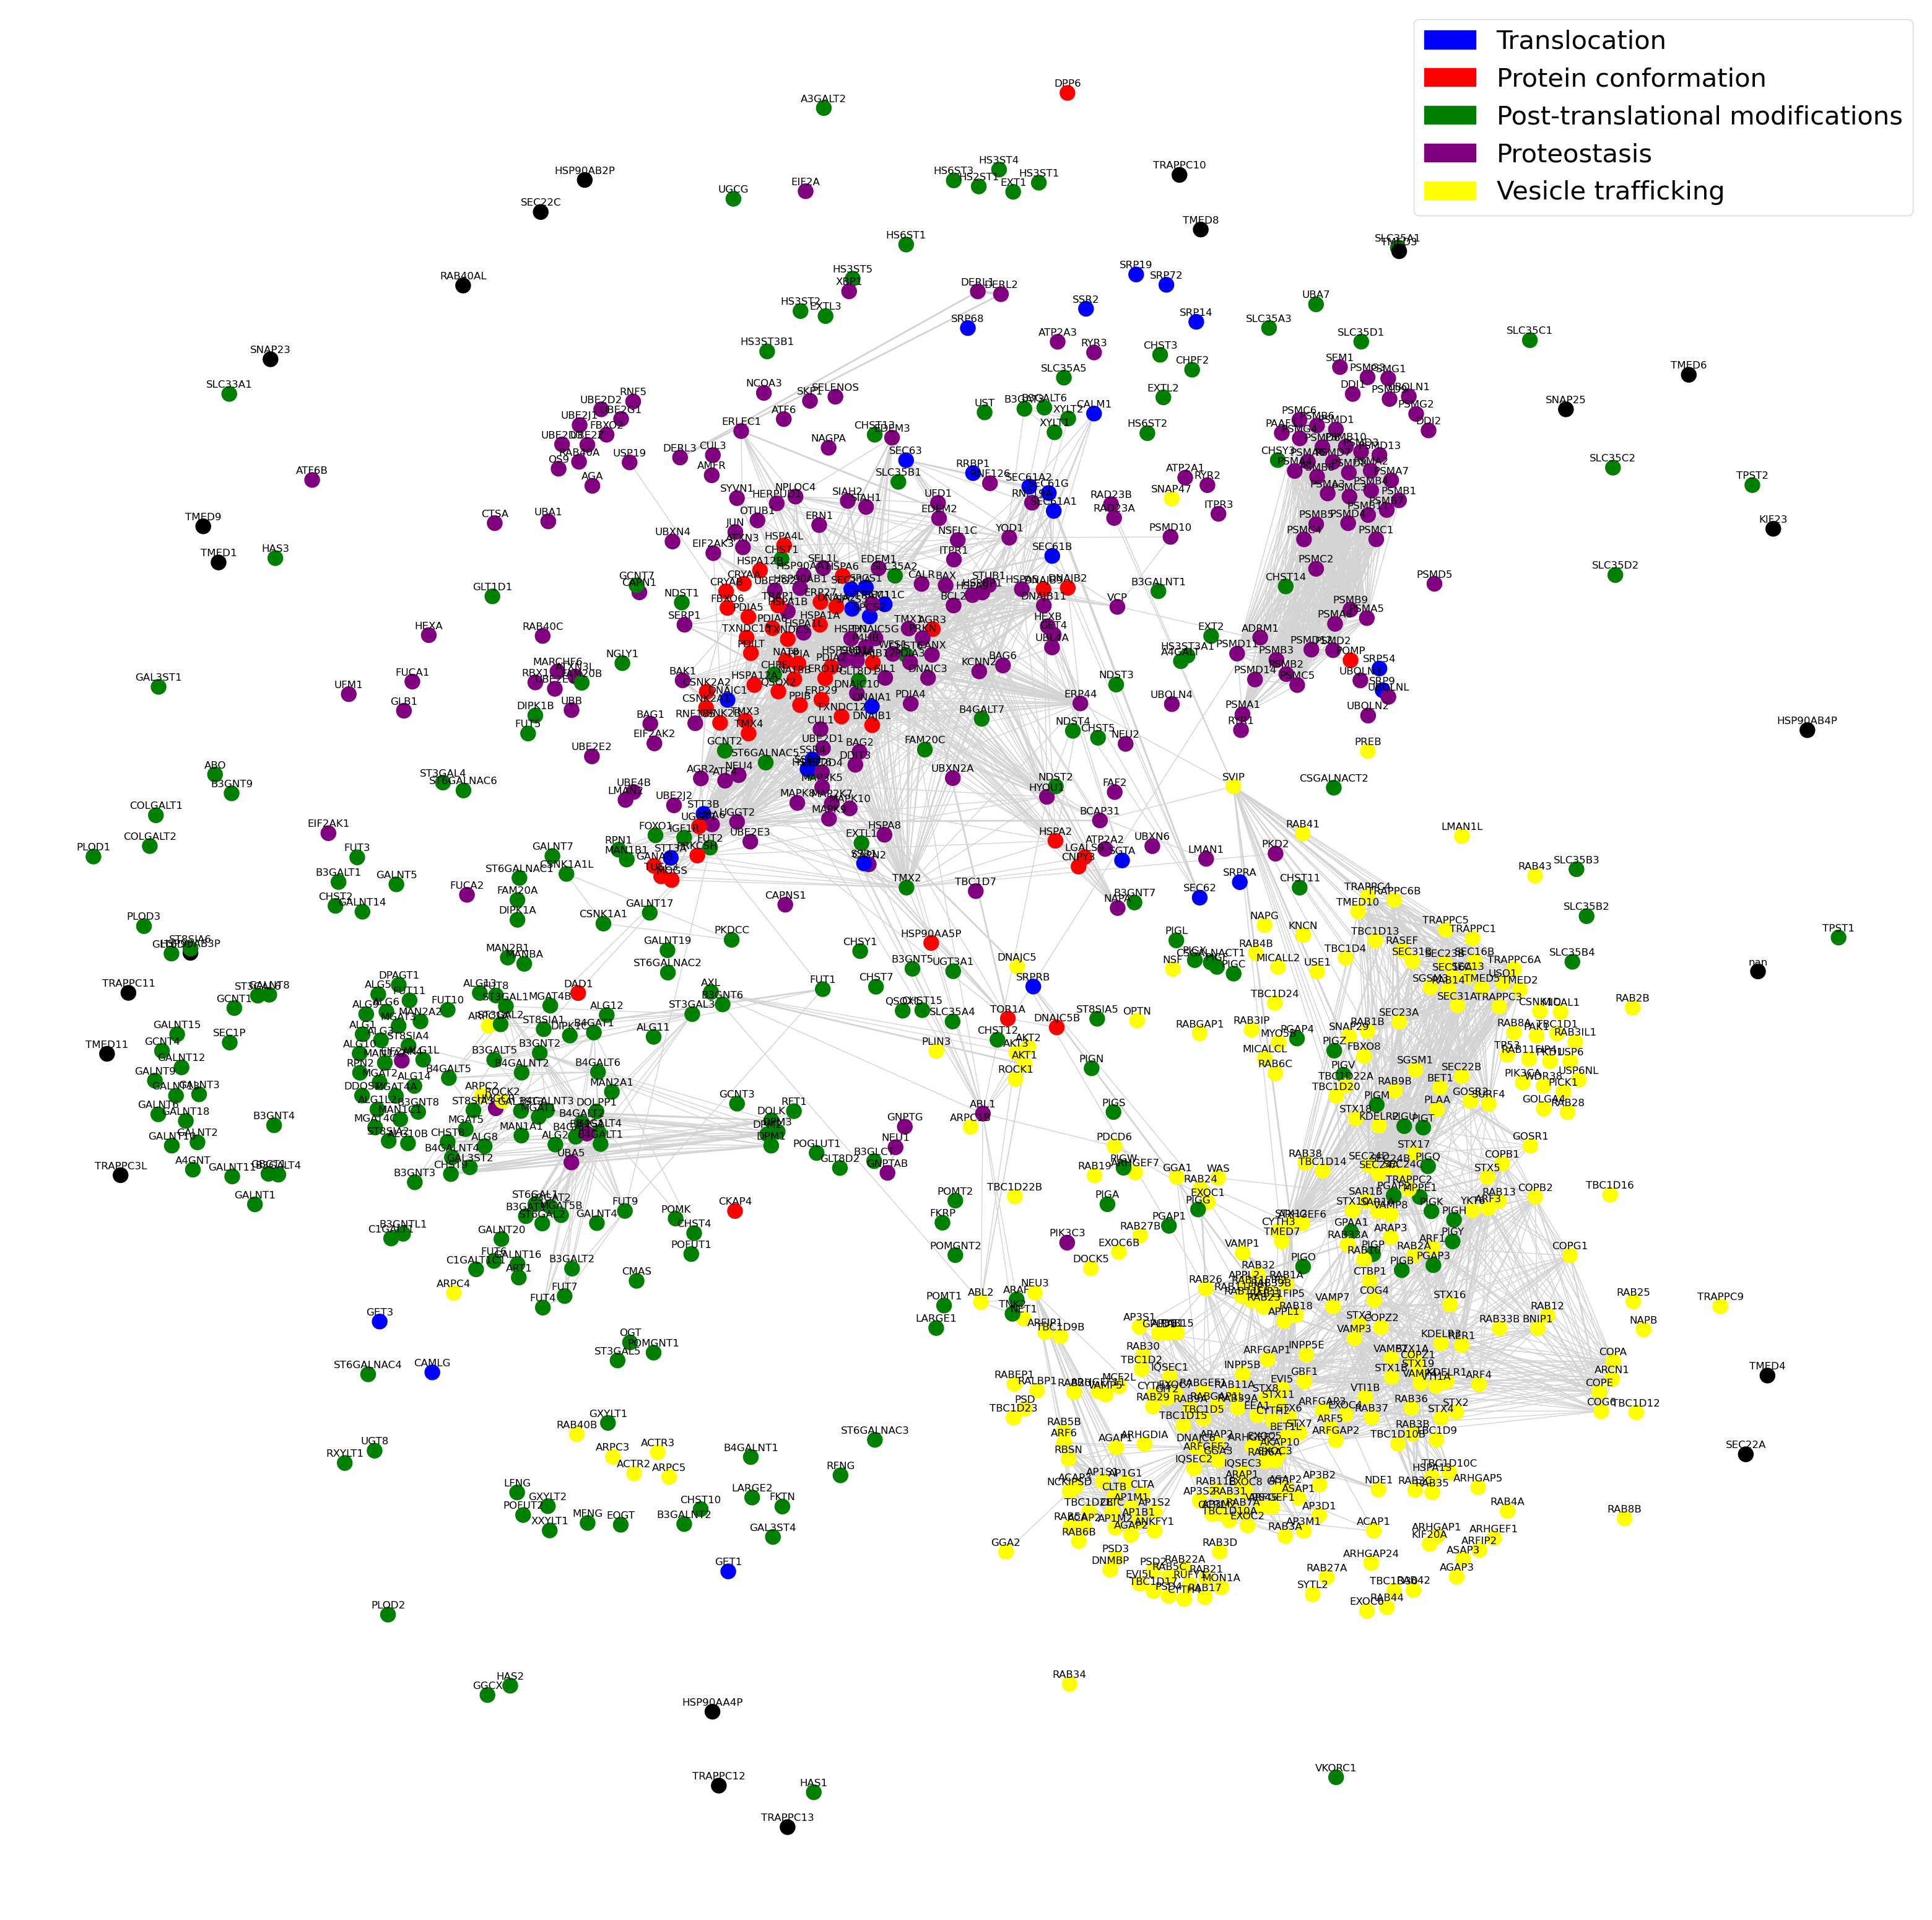

In [7]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    if shared_processes > 0:
        G.add_edge(gene1, gene2, weight=shared_processes)

# Color code node according to the System they belong to
node_colors = [get_gene_color(node, gene_dict, process_dict, category_colors) for node in G.nodes]

# Draw the graph
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.5)   # Set fixed position for nodes
# Only plot edges that are greater than 1 in weight
edgelist = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 1]

nx.draw(G, pos, node_color=node_colors, edgelist=edgelist, node_size=300, edge_color='lightgrey', 
        width=[G[u][v]['weight'] for u, v in G.edges()], ax=ax)  # Set edge width to be proportional to the shared processes

# labels
label_pos = {node: (coords[0], coords[1] + 0.01) for node, coords in pos.items()}
nx.draw_networkx_labels(G, label_pos, font_size=12) 

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 30}) 

plt.show()

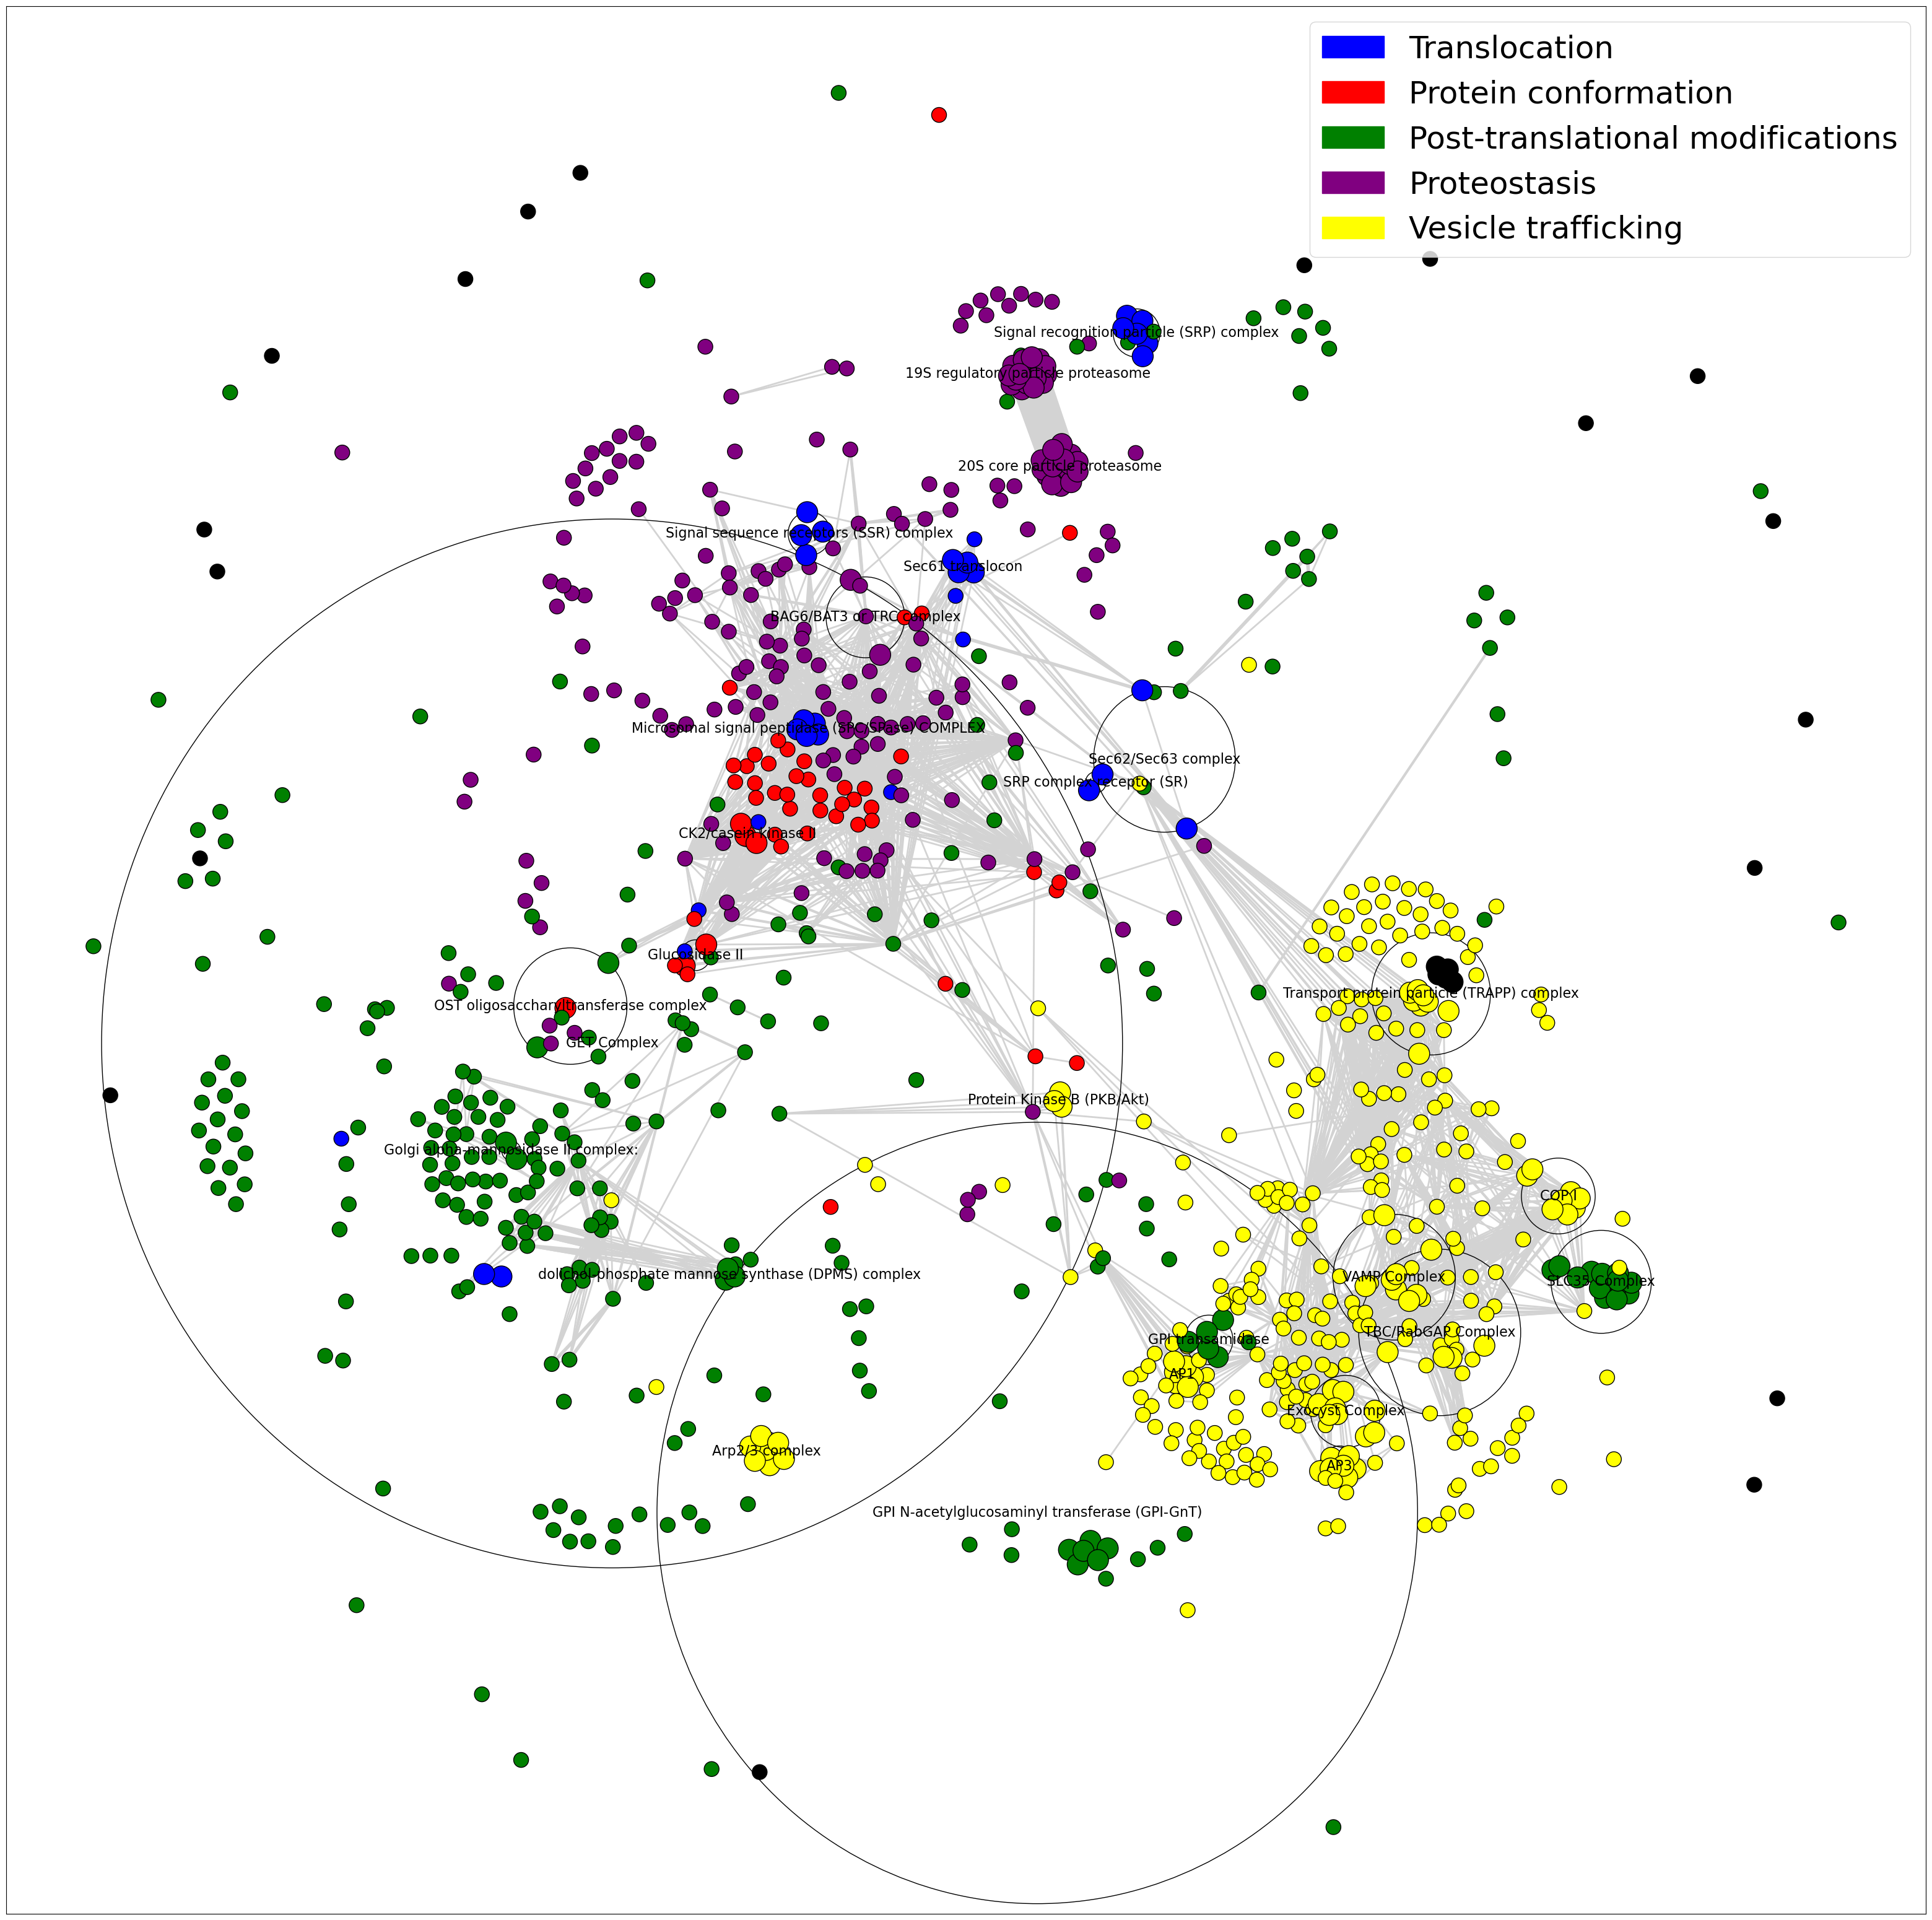

In [12]:
# Build the network
G = nx.Graph()

# Adding nodes
for gene in gene_dict:
    G.add_node(gene)

# Constants for edge weights
PROCESS_WEIGHT = 1
COMPLEX_WEIGHT = 100

# Adjusting the process of adding edges
for gene1, gene2 in combinations(gene_dict.keys(), 2):  # 2 for pairs
    # Calculate shared processes
    shared_processes = len(set(gene_dict[gene1]['processes']).intersection(gene_dict[gene2]['processes']))
    
    # Check for shared complex
    shared_complex = gene_dict[gene1]['complex'] == gene_dict[gene2]['complex'] and gene_dict[gene1]['complex'] != 'Not part of any complex'
    if shared_complex:
        edge_weight = COMPLEX_WEIGHT
        G.add_edge(gene1, gene2, weight=edge_weight)
    elif shared_processes > 0:
        edge_weight = shared_processes * PROCESS_WEIGHT
        G.add_edge(gene1, gene2, weight=edge_weight)
        
# Color code node according to the System they belong to
node_colors = [get_gene_color(node, gene_dict, process_dict, category_colors) for node in G.nodes]

# Adjust node sizes according to whether they are part of a complex
node_sizes = [600 if gene_dict[node]['complex'] != 'Not part of any complex' else 300 for node in G.nodes]

# Draw the graph
fig, ax = plt.subplots(figsize=(40, 40))
pos = nx.spring_layout(G, seed=42, iterations=50, k=0.4)   # Set fixed position for nodes

# Create dictionary to store each complex's nodes' positions
complex_positions = {}

for gene in G.nodes:
    complex_ = gene_dict[gene]['complex']
    
    # Check if the gene is part of any complex
    if complex_ == 'Not part of any complex':
        continue
    
    # If the complex field is a list, iterate over each complex
    if isinstance(complex_, list):
        for comp in complex_:
            if comp not in complex_positions:
                complex_positions[comp] = []
            complex_positions[comp].append(pos[gene])
    else:  # If the complex field is a string, add the gene to the corresponding complex
        if complex_ not in complex_positions:
            complex_positions[complex_] = []
        complex_positions[complex_].append(pos[gene])
        
# Now compute average position and max radius for each complex
complex_centers_radii = {}
for complex_, positions in complex_positions.items():
    avg_position = np.mean(positions, axis=0)
    max_radius = max(np.linalg.norm(np.array(position)-avg_position) for position in positions)
    complex_centers_radii[complex_] = (avg_position, max_radius)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='black', linewidths=1)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color='lightgrey', 
                       width=[G[u][v]['weight'] for u, v in G.edges() if 100 > G[u][v]['weight'] > 1])

# Draw the circles for the complexes
for complex_, (center, radius) in complex_centers_radii.items():
    circle = Circle(center, radius, fill=False, edgecolor='black', lw=1)
    ax.add_patch(circle)
    ax.text(center[0], center[1], complex_, horizontalalignment='center', verticalalignment='center', fontsize=16)

# Legend
legend_patches = [mpatches.Patch(color=color, label=category) for category, color in category_colors.items()]
plt.legend(handles=legend_patches, prop={'size': 36}) 

plt.show()